In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import keras


In [2]:
dataset, info = tfds.load("cats_vs_dogs", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.S7TICY_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
info.splits

{Split('train'): <SplitInfo num_examples=23262, num_shards=16>}

In [4]:
info.splits["train"]

<SplitInfo num_examples=23262, num_shards=16>

In [5]:
class_names = info.features["label"].names
class_names

['cat', 'dog']

In [6]:
n_classes = info.features["label"].num_classes


In [7]:
dataset_size = info.splits["train"].num_examples
dataset_size

23262

In [8]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

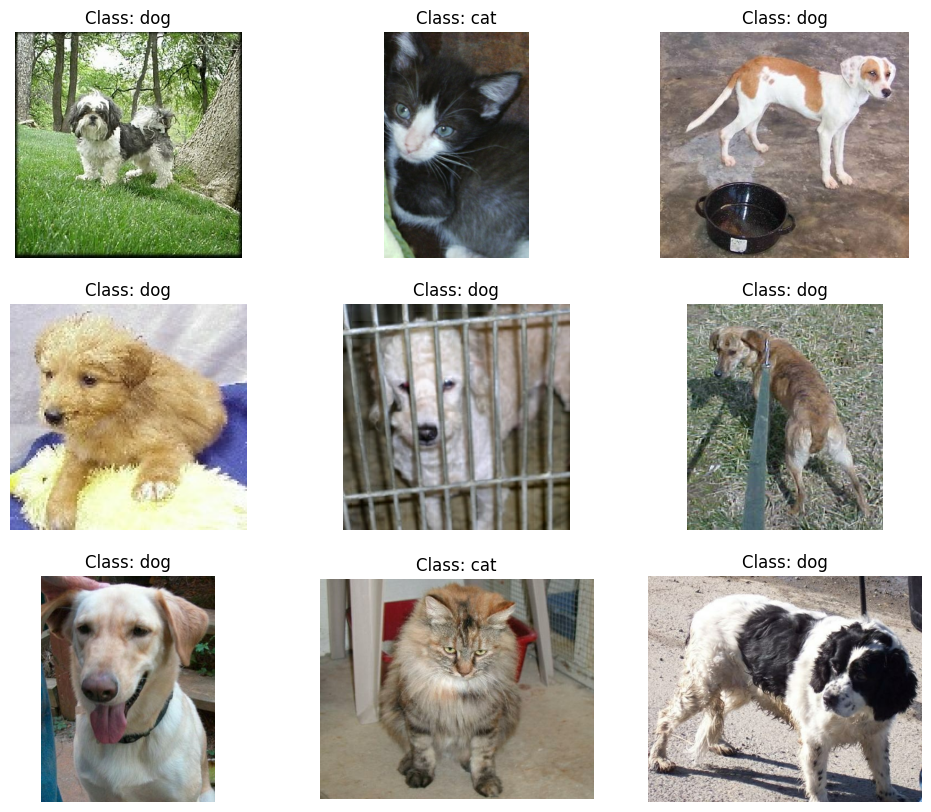

In [9]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [10]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [11]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

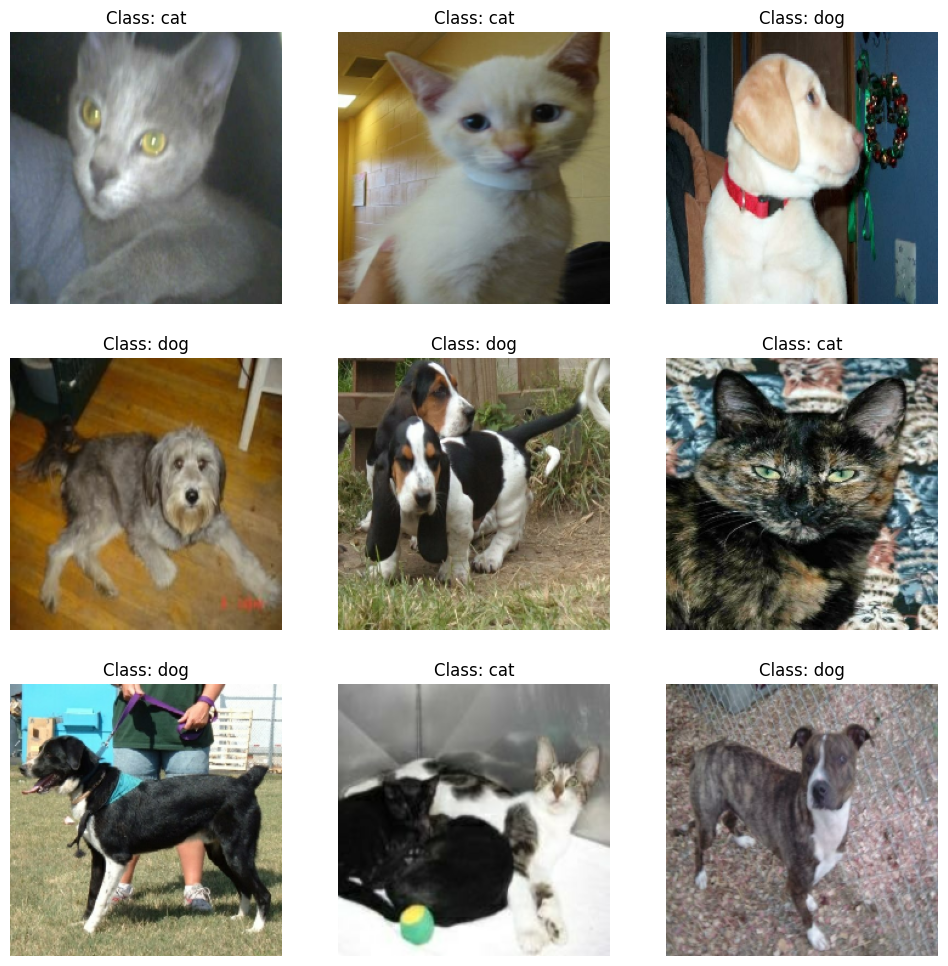

In [12]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [13]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_layer
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3

In [15]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
I0000 00:00:1725639736.982217      71 service.cc:145] XLA service 0x7abe90011500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725639736.982293      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725639736.982298      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/545 ━━━━━━━━━━━━━━━━━━━━ 2:29:06 16s/step - accuracy: 0.4688 - loss: 0.7515

I0000 00:00:1725639747.988997      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


545/545 ━━━━━━━━━━━━━━━━━━━━ 91s 138ms/step - accuracy: 0.9751 - loss: 0.1701 - val_accuracy: 0.9802 - val_loss: 0.2268
Epoch 2/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 68s 125ms/step - accuracy: 0.9896 - loss: 0.1019 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
  1/545 ━━━━━━━━━━━━━━━━━━━━ 1:00 111ms/step - accuracy: 1.0000 - loss: 3.3688e-05

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


545/545 ━━━━━━━━━━━━━━━━━━━━ 78s 144ms/step - accuracy: 0.9909 - loss: 0.0808 - val_accuracy: 0.9814 - val_loss: 0.2630
Epoch 4/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 66s 121ms/step - accuracy: 0.9902 - loss: 0.1001 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 79s 144ms/step - accuracy: 0.9927 - loss: 0.0696 - val_accuracy: 0.9874 - val_loss: 0.2044


In [16]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
545/545 ━━━━━━━━━━━━━━━━━━━━ 290s 468ms/step - accuracy: 0.9348 - loss: 0.2744 - val_accuracy: 0.9828 - val_loss: 0.0431
Epoch 2/40
545/545 ━━━━━━━━━━━━━━━━━━━━ 241s 442ms/step - accuracy: 0.9919 - loss: 0.0257 - val_accuracy: 1.0000 - val_loss: 1.1921e-06
Epoch 3/40
545/545 ━━━━━━━━━━━━━━━━━━━━ 253s 464ms/step - accuracy: 0.9978 - loss: 0.0071 - val_accuracy: 0.9862 - val_loss: 0.0415
Epoch 4/40
545/545 ━━━━━━━━━━━━━━━━━━━━ 240s 440ms/step - accuracy: 0.9994 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/40
545/545 ━━━━━━━━━━━━━━━━━━━━ 253s 464ms/step - accuracy: 0.9991 - loss: 0.0024 - val_accuracy: 0.9880 - val_loss: 0.0445
Epoch 6/40
545/545 ━━━━━━━━━━━━━━━━━━━━ 240s 440ms/step - accuracy: 1.0000 - loss: 5.2089e-04 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/40
545/545 ━━━━━━━━━━━━━━━━━━━━ 253s 464ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9874 - val_loss: 0.0518
Epoch 8/40
545/545 ━━━━━━━━━━━━━━━━━━━━ 249s 457ms/step - ac